In [16]:
from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
import h5py
import multiprocessing as mp
import os
import re
import numpy as np
import time
import xarray as xr
from itertools import groupby


from calibration import parse_ids
from karabo_data import DataCollection, by_index, RunDirectory, stack_detector_data
from karabo_data.geometry2 import LPD_1MGeometry

import matplotlib.pyplot as plt
%matplotlib notebook

In [ ]:
run = RunDirectory("/gpfs/exfel/exp/FXE/201931/p900089/raw/r0055")

In [ ]:
run.info()

In [ ]:
counts = run.get_data_counts("FXE_DET_LPD1M-1/DET/10CH0:xtdf", "image.data")
counts[counts != 0]

In [ ]:
tid, data = run.train_from_index(20)

In [ ]:
data["FXE_RR_DAQ/ADC/1:network"].keys()

In [ ]:
dig = data["FXE_RR_DAQ/ADC/1:network"]["digitizers.channel_3_B.raw.samples"]
dig.shape

In [ ]:
%matplotlib notebook
plt.plot(np.arange(5000), dig[10000:15000])

In [ ]:
digitizer_data = run.get_array("FXE_RR_DAQ/ADC/1:network", "digitizers.channel_3_B.raw.samples")

In [ ]:
digitizer_data.shape

In [ ]:
%matplotlib notebook

plt.plot(range(digitizer_data.shape[1]), np.abs(digitizer_data.values[0, :]))


# Evaluate dark offset

In [62]:
def dark_offset(module_number, path, *, pulse_ids=None):
    """ Process Dark data

    Parameters
    ----------
    module_number: int
        Channel number between 0, 15
    path: str
        Path to Run folder
    pulse_ids: str
        For eg. ":" to select all pulses in a train
                "start:stop:step" to select indices with certain step size
                "1,2,3" comma separated pulse index to select specific pulses
                "1,2,3, 5:10" mix of above two
        Default: all pulses ":"
        
    Return
    ------
    out: ndarray
        Shape: (n_pulses, ..., slow_scan, fast_scan)
    """

    if not path or module_number not in range(16):
        return

    pattern = f"(.+)LPD{module_number:02d}(.+)"

    files = [os.path.join(path, f) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)]

    if not files:
        return

    run = DataCollection.from_paths(files)

    module = [key for key in run.instrument_sources
              if re.match(r"(.+)/DET/(.+):(.+)", key)]

    if len(module) != 1:
        return
    
    run = run.select([(module[0], "image.data")])
    
    pulse_ids = ":" if pulse_ids is None else pulse_ids
    pulses = parse_ids(pulse_ids)
    
    mean_image = 0
    counts = 0
    for tid, data in run.trains():
        image = np.squeeze(data[module[0]]["image.data"], axis=1) # (pulses, 1, ss, fs)
        
        if image.shape[0] == 0:
            continue
        
        if pulses != [-1]:
            image = image[pulses, ...].astype(np.float32)
        else:
            image = image.astype(np.float32)
              
        mean_image += image
        counts += 1
    
    if counts != 0:
        return mean_image / counts


In [63]:
modules = "0:16"
pulse_ids = "6, 7, 8, 9, 10"

highgain_dark_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0049"
mediumgain_dark_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0050"
lowgain_dark_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0051"

module_numbers = parse_ids(modules)

dark_data = {"high":{}, "medium":{}, "low":{}}

print(module_numbers)
print(parse_ids(pulse_ids))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[6, 7, 8, 9, 10]


### High Gain dark evaluation

In [65]:
_dark_eval = partial(dark_offset, 
                     path=highgain_dark_folder, 
                     pulse_ids=pulse_ids)

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data["high"][modno] = ret

print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")     

Time to evaluate roi intensities: 67.55597724765539


In [ ]:
dark_data["high"][14].shape

### Medium Gain dark evaluation

In [67]:
_dark_eval = partial(dark_offset, 
                     path=mediumgain_dark_folder, 
                     pulse_ids=pulse_ids)

t0 = time.perf_counter()
with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data["medium"][modno] = ret

print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

Time to evaluate roi intensities: 69.8361420109868


### Low Gain dark evaluation

In [66]:
_dark_eval = partial(dark_offset, 
                     path=lowgain_dark_folder, 
                     pulse_ids=pulse_ids)

t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(module_numbers, executor.map(_dark_eval, module_numbers)):
        dark_data["low"][modno] = ret

print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

Time to evaluate roi intensities: 70.415999840945


# Write dark offset to file

In [71]:
dark_data_file = "/home/kamile/data/dark_data.h5"

with h5py.File(dark_data_file, "w") as f:
    for gain in dark_data.keys():
        g = f.create_group(f"entry_1/instrument/gain_{gain}")
        for modno, data in dark_data[gain].items():
            if data is not None:
                h = g.create_group(f"module_{modno}")
                h.create_dataset('data', data=data)


<IPython.core.display.Javascript object>


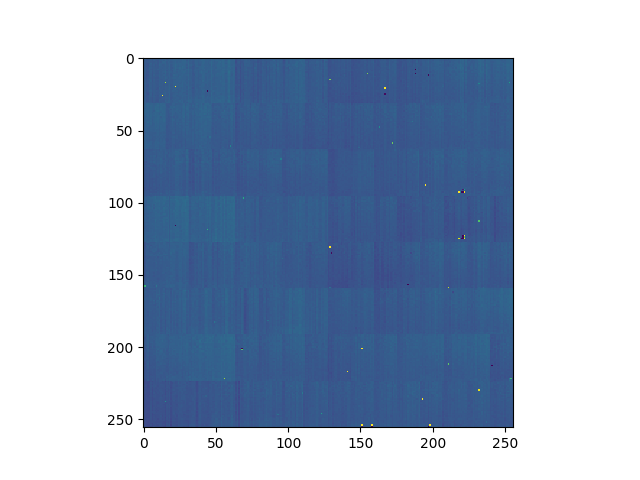

In [72]:
%matplotlib notebook

plt.imshow(dark_data["high"][15][2])

# Delay scan

In [22]:
def module_roi_intensity(module_number, path, *, pulse_ids=None, rois=None):
    
    if not path or module_number not in range(16):
        return

    pattern = f"(.+)LPD{module_number:02d}(.+)"

    files = [os.path.join(path, f) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)]

    if not files:
        return

    run = DataCollection.from_paths(files)

    module = [key for key in run.instrument_sources
              if re.match(r"(.+)/DET/(.+):(.+)", key)]

    if len(module) != 1:
        return
    
    run = run.select([(module[0], "image.data")])
    
    pulse_ids = ":" if pulse_ids is None else pulse_ids
    pulses = parse_ids(pulse_ids)
    
    intensities = []
    train_ids = []
    
    for tid, data in run.trains():
        image = np.squeeze(data[module[0]]["image.data"], axis=1) # (pulses, 1, ss, fs)
        
        if image.shape[0] == 0:
            continue
        
        if rois is not None:
            x0, x1, y0, y1 = rois
            image = image[..., x0:x1, y0:y1]
        
        if pulses != [-1] and image.shape[0] != 0:
            image = image[pulses, ...].astype(np.float32)
        else:
            image = image.astype(np.float32)
        
        intensities.append(np.mean(image, axis=(-1,-2)))
        train_ids.append(tid)
    
    if not intensities or not train_ids:
        return
    
    coords = {'trainId':np.array(train_ids)}
    dims = ['trainId', 'dim_0']
    data = xr.DataArray(np.stack(intensities), dims=dims, coords=coords)

    return data

In [34]:
modules = "0:16"
pulse_ids = "6, 7, 8, 9, 10"

highgain_run_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0056"
mediumgain_run_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0057"
lowgain_run_folder = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0058"

module_numbers = parse_ids(modules)

roi_intensities = {"high":{}, "medium":{}, "low":{}}


### High Gain ROI intensities

In [35]:
_roi_intensity_eval = partial(module_roi_intensity, 
                              path=highgain_run_folder, 
                              pulse_ids=pulse_ids,
                              rois=rois)
t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(
        module_numbers, executor.map(_roi_intensity_eval, module_numbers)):
        roi_intensities["high"][modno] = ret
        
print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

Time to evaluate roi intensities: 649.9066184014082


### Medium Gain ROI intensities

In [36]:
_roi_intensity_eval = partial(module_roi_intensity, 
                              path=mediumgain_run_folder, 
                              pulse_ids=pulse_ids,
                              rois=rois)
t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(
        module_numbers, executor.map(_roi_intensity_eval, module_numbers)):
        roi_intensities["medium"][modno] = ret
        
print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")

Time to evaluate roi intensities: 738.036528069526


### Low Gain ROI intensities

In [37]:
_roi_intensity_eval = partial(module_roi_intensity, 
                              path=lowgain_run_folder, 
                              pulse_ids=pulse_ids,
                              rois=rois)
t0 = time.perf_counter()

with ProcessPoolExecutor(max_workers=len(module_numbers)) as executor:
    for modno, ret in zip(
        module_numbers, executor.map(_roi_intensity_eval, module_numbers)):
        roi_intensities["low"][modno] = ret
        
print(f"Time to evaluate roi intensities: {time.perf_counter() - t0}")
       

Time to evaluate roi intensities: 680.3577453680336


### Write RoI intensities to file

In [38]:
roi_intensities_file = "/home/kamile/data/roi_intensities.h5"


with h5py.File(roi_intensities_file, "w") as f:
    for gain in roi_intensities.keys():
        g = f.create_group(f"entry_1/instrument/gain_{gain}")
        for modno, data in roi_intensities[gain].items():
            if data is not None:
                h = g.create_group(f"module_{modno}")
                h.create_dataset('trainId', data=data['trainId'])
                h.create_dataset('data', data=data)


# Get Delay arrays

In [40]:
delay_src = "FXE_RR_SYS/TSYS/UTC-1-S3"
delay_prop = "backTrg3.delay.value"

delay_data = {}


# High Gain delay
run = RunDirectory(highgain_run_folder)
# get delay data: xarray
delay_data['high'] = run.get_array(delay_src, delay_prop)
delay_data['high'] = delay_data['high'].expand_dims('dim_1', axis=1)


# Medium Gain delay
run = RunDirectory(mediumgain_run_folder)
# get delay data: xarray
delay_data['medium'] = run.get_array(delay_src, delay_prop)
delay_data['medium'] = delay_data['medium'].expand_dims('dim_1', axis=1)

# Low Gain delay
run = RunDirectory(lowgain_run_folder)
# get delay data: xarray
delay_data['low'] = run.get_array(delay_src, delay_prop)
delay_data['low'] = delay_data['low'].expand_dims('dim_1', axis=1)


print(delay_data['high'])

<xarray.DataArray (trainId: 4720, dim_1: 1)>
array([[6381521],
       [6381521],
       [6381521],
       ...,
       [6381521],
       [6381521],
       [6381521]], dtype=int32)
Coordinates:
  * trainId  (trainId) uint64 589035425 589035426 ... 589040143 589040144
Dimensions without coordinates: dim_1


In [ ]:
delay_data.values[:].shape
%matplotlib notebook
plt.plot(range(len(delay_data.values[:, 0])), delay_data.values[:,0], '-o'  )

## Align delay data with ROI Intesities along TrainIds and plot


<IPython.core.display.Javascript object>


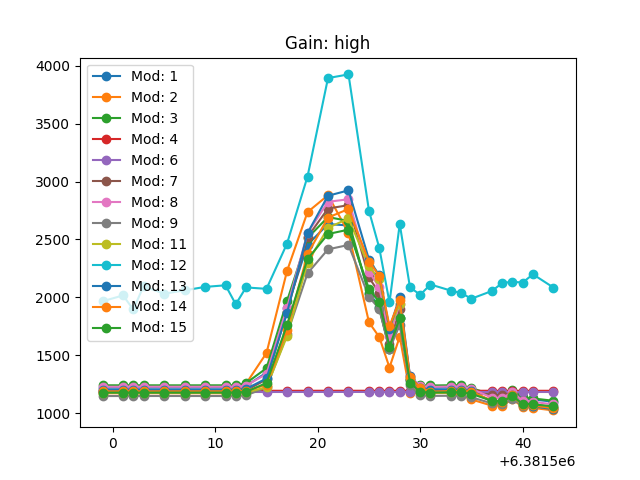

<IPython.core.display.Javascript object>


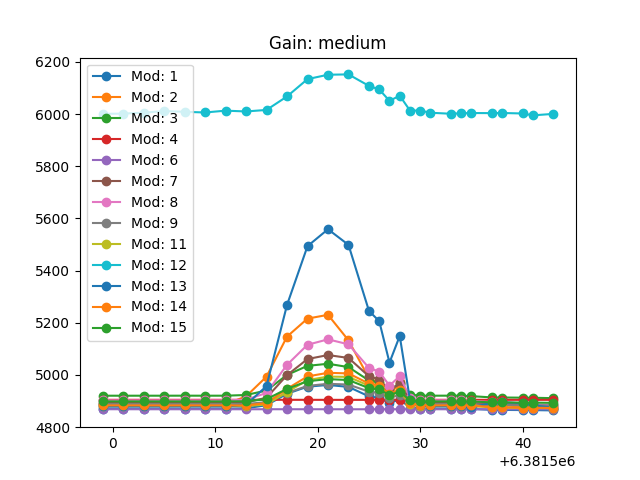

<IPython.core.display.Javascript object>


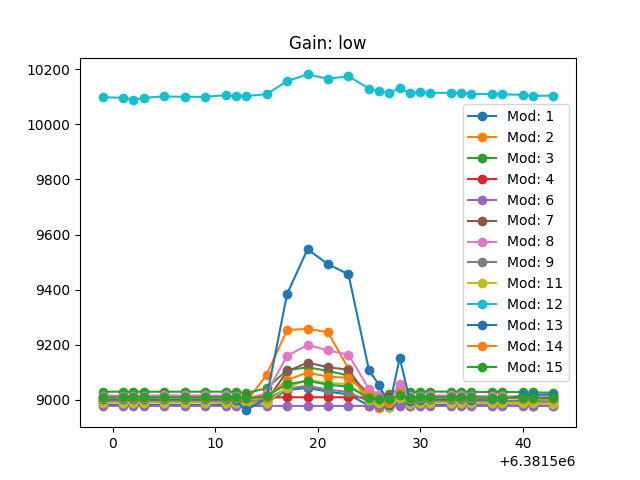

In [41]:
import  matplotlib.pyplot as plt
%matplotlib notebook

pulse = 2

for gain in roi_intensities.keys():
    fig, ax = plt.subplots(1, 1)
    for modno in module_numbers:
        if roi_intensities[gain][modno] is not None:
            roi_int, delay = xr.align(roi_intensities[gain][modno], delay_data[gain])

            s = list(zip(delay[:, 0].values, roi_int[:, pulse].values))
            roi_int_avg = []
            roi_int_std = []
            delay = []
            for key, group in groupby(sorted(s), lambda x: x[0]):
                x, y = zip(*group)
                avg, std = np.mean(np.array(y)), np.std(np.array(y))
                roi_int_avg.append(avg)
                roi_int_std.append(std)
                delay.append(x[0])        
            
            #ax.errorbar(delay, roi_int_avg, yerr=roi_int_std, uplims=True, lolims=True)
            ax.plot(delay, roi_int_avg, '-o', label=f"Mod: {modno}")
            ax.legend()
            ax.set_title(f"Gain: {gain}")


In [69]:
roi_int, delay = xr.align(roi_intensities["low"][12], delay_data["low"])
s = list(zip(delay[:, 0].values, roi_int[:, 2].values))
average = []
d = []
for key, group in groupby(sorted(s), lambda x: x[0]):
    x, y = zip(*group)
    avg = np.mean(np.array(y))
    average.append(avg)
    d.append(x[0])

li = zip(d, average)


sorted(li, key=lambda x: x[1], reverse=True)

[(6381519, 10181.234),
 (6381523, 10174.586),
 (6381521, 10165.484),
 (6381517, 10156.694),
 (6381528, 10131.664),
 (6381525, 10129.841),
 (6381526, 10120.543),
 (6381530, 10115.7705),
 (6381534, 10115.324),
 (6381533, 10114.618),
 (6381527, 10114.552),
 (6381531, 10113.989),
 (6381529, 10113.177),
 (6381537, 10110.559),
 (6381535, 10109.911),
 (6381515, 10109.481),
 (6381538, 10108.949),
 (6381540, 10107.01),
 (6381511, 10105.637),
 (6381543, 10104.2295),
 (6381541, 10103.014),
 (6381513, 10102.502),
 (6381512, 10101.6),
 (6381505, 10101.148),
 (6381507, 10099.89),
 (6381509, 10099.6875),
 (6381499, 10098.098),
 (6381503, 10096.633),
 (6381501, 10096.361),
 (6381502, 10087.771)]

# LPD ROI intensity with Offset and Relative gain correction

In [73]:
def lpd_corrections(sequence, path, *, pulse_ids=None, rois=None, dark_data=None):
    
    if not path:
        return

    pattern = f"(.+)LPD(.+)-S{sequence}"

    files = [os.path.join(path, f) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)]
    if not files:
        return
    
    devices = [("*/DET/*CH0:xtdf", "image.data")]
    run = DataCollection.from_paths(files).select(devices)
    
    pulse_ids = ":" if pulse_ids is None else pulse_ids
    pulses = parse_ids(pulse_ids)
    
    out_array = None
    quad_positions = [[11.4, 299],
                      [-11.5, 8],
                      [254.5, -16],
                      [278.5, 275]]
    filename = os.path.join(
        os.getcwd(),'calibration/geometries/lpd_mar_18_axesfixed.h5')

    geom = LPD_1MGeometry.from_h5_file_and_quad_positions(
        filename, quad_positions)
    
    mean = 0
    count = 0
    intensities = []
    train_ids = []
    
    for tid, data in run.trains():
        
        def _corrections(source):
            pattern = "(.+)/DET/(.+)CH0:xtdf"
            modno = (re.match(pattern, source)).group(2)
            
            try:
                image = np.squeeze(data[source]["image.data"], axis=1)
            except KeyError as e:
                return
            
            if pulses != [-1] and image.shape[0] != 0:
                image = image[pulses, ...].astype(np.float32)
            else:
                image = image.astype(np.float32)
                        
            if dark_data is not None and image.shape[0] != 0:
                high, medium, low = \
                    dark_data["high"][modno], dark_data["medium"][modno], dark_data["low"][modno]
                
                if all([high is not None, medium is not None, low is not None]):
                    currim = np.zeros_like(image)
                    
                    # High gain
                    corrim = image - high
                    currim[image <= 4096] = corrim[image <= 4096]
                    
                    # Medium gain
                    corrim = (image - medium) * 9.85
                    currim[(image <= 8192) & (image > 4096)] = \
                        corrim[(image <= 8192) & (image >4096)]
                    
                    # Low gain
                    corrim = (image - low) * 9.85 * 7.44
                    currim[image > 8192] = corrim[image > 8192]
                    
                    image = currim
            
            data[source]["image.data"] = image
        
        with ThreadPoolExecutor(max_workers=len(data.keys())) as executor:
            for source in data.keys():
                executor.submit(_corrections, source)
        
        # assemble image        
        try:
            stacked_data = stack_detector_data(data, "image.data")  
        except (ValueError, IndexError, KeyError) as e:
            continue

        n_images = (stacked_data.shape[0], )
        if stacked_data.shape[0] == 0:
            continue
        
        image_dtype = stacked_data.dtype
        
        if out_array is None:
            out_array = geom.output_array_for_position_fast(
                extra_shape=n_images, dtype=image_dtype)
        
        assembled, centre = geom.position_all_modules(
                stacked_data, out=out_array)
        
        if rois is not None:
            x0, x1, y0, y1 = rois
            assembled = assembled[..., x0:x1, y0:y1]
            
        mean += assembled
        count += 1
        
        intensities.append(np.nanmean(assembled, axis=(-1,-2)))
        train_ids.append(tid)
    
    if not intensities or not train_ids:
        return
    coords = {'trainId':np.array(train_ids)}
    dims = ['trainId', 'dim_0']
    data = xr.DataArray(np.stack(intensities), dims=dims, coords=coords)
        
    return mean / count, data


In [78]:
path = "/gpfs/exfel/exp/FXE/201931/p900089/raw/r0055"

pattern = f"(.+)LPD(.+)-S(.+).h5"
sequences = {re.match(pattern, f).group(3) for f in os.listdir(path)
             if f.endswith('.h5') and re.match(pattern, f)}

_lpd_corrections = partial(lpd_corrections, 
                           path=path,
                           pulse_ids="6:11",
                           dark_data=dark_data,
                          )

print(sequences)

with ProcessPoolExecutor(max_workers=len(sequences)) as executor:
    ret = executor.map(_lpd_corrections, list(sequences) )



{'00001', '00002', '00000'}


# Digitizer data

In [74]:
from scipy.signal import find_peaks


In [75]:
run = RunDirectory("/gpfs/exfel/exp/FXE/201931/p900089/raw/r0055")
digitizer_data = run.get_array("FXE_RR_DAQ/ADC/1:network", "digitizers.channel_4_D.raw.samples")   

digitizer_data = np.abs(digitizer_data)

digitizer_data

<xarray.DataArray (trainId: 669, dim_0: 600000)>
array([[15, 18, 14, ..., 13, 18, 15],
       [15, 15, 17, ..., 14, 15, 16],
       [18, 14, 17, ..., 15, 14, 13],
       ...,
       [13, 16, 13, ..., 17, 18, 13],
       [15, 16, 16, ..., 15, 18, 18],
       [16, 16, 17, ..., 16, 20, 17]], dtype=int16)
Coordinates:
  * trainId  (trainId) uint64 589004881 589004882 ... 589005548 589005549
Dimensions without coordinates: dim_0

In [69]:
digitizer_data[:, 10000:15000]
digitizer_data[:, 10000:15000].dim_0

<xarray.DataArray 'dim_0' (dim_0: 14000)>
array([    0,     1,     2, ..., 13997, 13998, 13999])
Dimensions without coordinates: dim_0

<IPython.core.display.Javascript object>


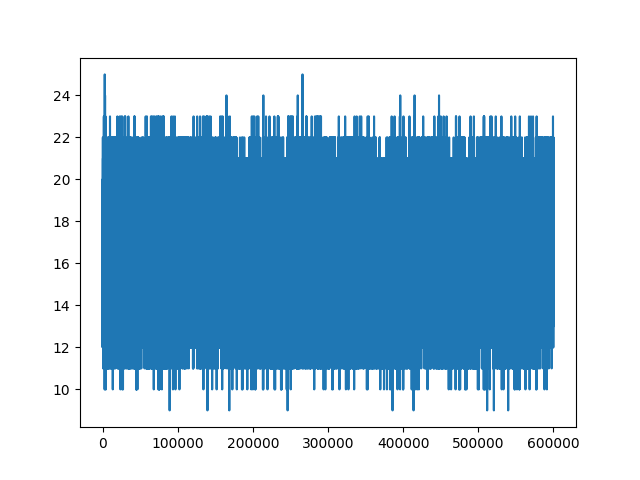

In [77]:
%matplotlib notebook

fig, ax = plt.subplots(1, 1)
ax.plot(digitizer_data.dim_0, digitizer_data[0,:])

In [64]:
def digitizer_normalizer(digitizer_data, height=100, distance=100):
    num_train = digitizer_data['trainId'].shape[0]
    normalizer = []
    for train in range(num_train):
        peaks, _ = find_peaks(digitizer_data.values[train, :], height=height, distance=distance)
        
        normalizer_train = []
        for peak in peaks:
            integral = np.sum(digitizer_data.values[0, :][peak-50:peak+50])
            normalizer_train.append(integral)

        normalizer.append(np.stack(normalizer_train))
    return normalizer
        

norm = digitizer_normalizer(digitizer_data, height=75, distance=100)
        